# Dabbling with quantitative finance using Python


### What is quantitative finance?
Quantitative finance is the use of mathematical models and extremely large datasets to analyze financial markets and securities. In general, there exist two separate branches of finance that require advanced quantitative techniques: risk and portfolio management on one hand & derivatives pricing on the other. We are going to just touch the surface of the first one.

So the objective of the talk is to give you a different *perspective* on stock markets, a perspective that is based on statistical analysis and along the way learn few key concepts, namely-

* What is return or reward?
* What is Risk?
* How do we use deal with risk?
* What is beta and what are its applications?

### A word of caution
Do not attempt any trading based on today's talk, But this is just an introduction, it takes much more than just theoretical knowledge.

We can only do so much in an hour.  We have too much to cover so I will take questions offline in chat.

So let's get started, I will not go thru the code line by line because I will share this notebook at the end.

# Getting the data

We will be working with daily stock price data. There are multiple Python libraries to download this data. Today I will use `yfinance`.

Let's get started, we will get last five year the the data for ICICI Bank

In [70]:
import yfinance as yf
import pickle
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning) # Not optimizing for performance
simplefilter(action="ignore", category=FutureWarning) # Not concerned about future compatibility
YEARS=5

In [27]:
s1 = yf.Ticker('ICICIBANK.NS').history(period='5y')
s1.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-02-18 00:00:00+05:30,335.576749,336.361253,331.016726,332.193512,10601490,0.0,0
2019-02-19 00:00:00+05:30,332.536774,343.618052,332.536774,336.606445,14384763,0.0,0
2019-02-20 00:00:00+05:30,338.322566,340.872250,335.723863,338.518707,9474758,0.0,0
2019-02-21 00:00:00+05:30,340.087707,348.079989,339.548365,344.500610,18631331,0.0,0
2019-02-22 00:00:00+05:30,344.598701,347.246455,344.500631,345.236115,10997730,0.0,0


Briefly, understanding the columns
```
Open: When the market opened at 9:15, what was the price
High: Highest price during the day
Low:  Lowest price during day
Close: Price at the day end
Volume: How many shares traded
```
Let's calculate the daily returns-

<Axes: xlabel='Date'>

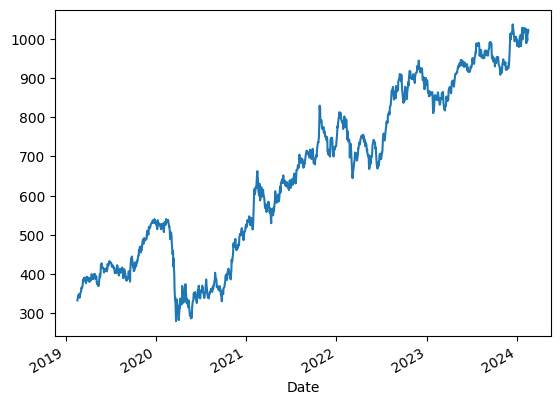

In [28]:
s1['Close'].plot()

# Returns
Lets learn what is daily return, absolute return and CAGR (Compound annual growth rate)

In [29]:
s1['Prev. Close'] = s1['Close'].shift(1)
s1['Return'] = s1['Close']/s1['Prev. Close'] - 1
s1 = s1.dropna()

In [71]:
print(f"Max single day fall : {min(s1['Return']*100):.2f} %")
print(f"Max single day rise : {max(s1['Return']*100):.2f} %")
print(f"Average daily gain: {s1['Return'].mean()*100:.2f} %") 

Max single day fall : -17.85 %
Max single day rise : 13.76 %
Average daily gain: 0.11 %


What was the absolute return, that is had we invested in icici at the beginning of the period (5 years back) what would be its return today?

In [31]:
abs_return = s1['Close'].iloc[-1] / s1['Close'].iloc[0] - 1
print(f"Absolute return : {(abs_return * 100):.2f}%")

Absolute return : 203.99%


CAGR - Compounded annual growth rate
$$
  CAGR = (V_{final}/V_{initial})^{(1/t)} -1
$$



In [32]:
CAGR = (s1['Close'].iloc[-1] / s1['Close'].iloc[0]) ** (1/YEARS) - 1
print(f"CARG : {(CAGR * 100):.2f}%")

CARG : 24.90%


# Risk

Let's consider two individuals, one software developer employed in a company with a salary of 1L, and second software developer is a freelancer who may get 3L in a good month and 0 in a bad month. Which profession is risky?

In stock market, risk is variation in returns. If you invest in a fixed deposit with interest say 6% then you will receive a return of 0.5% every month, there is no variation in return hence there is no risk. However in our above example we can see that the stock gave 24% CAGR, Does this mean that stock gave approximate 2% return every month like a fixed deposit? No.There were days when it fell 17% just in a day, **So this is the risk.** Sometimes also called as volatility.

But how is risk measured? It is measured by standard deviation $\sigma$ of returns. Mathematically, standard deviation is square root of variance. Which in turn is average of difference between each data point and its mean. Intutively it is measuring how much variation is there from the mean.

$$ \sigma = \frac {\sqrt{ \sum \limits _{i=1} ^ n {(x_i-\mu)^2}}}  {2}$$

Fortunately `pandas` provides this already, let's use this.

In [43]:
print(f"Standard Deviation of daily returns: {s1['Return'].std()*100:.2f}")

Standard Deviation of daily returns: 2.07


Higher the standard deviation, higher the risk/volatility. Let's look at the distribution of returns.


array([[<Axes: title={'center': 'Return'}>]], dtype=object)

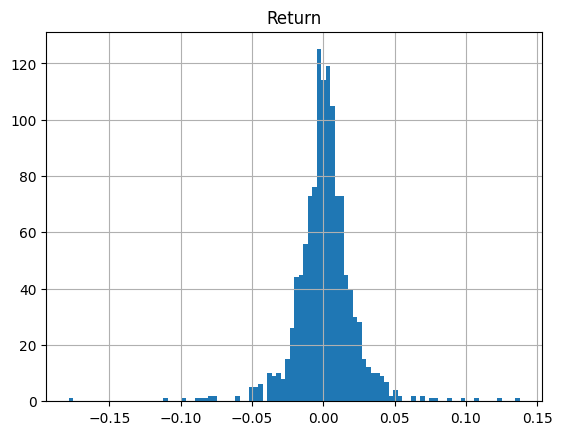

In [45]:
s1.hist(column='Return', bins=100)

This looks very much like normal distribution

<img src="https://swapniljariwala.github.io/normal-dist.webp" alt="Drawing" style="width: 500px;"/>

This observation is not so relevant for today's talk but this is very useful in options pricing. Besides that, I just want to spend a a minute on normal distribution. This is the most important statistical tool one can learn. You will come across it in lot of areas, for example sales pattern for daily products like soap etc, in healthcare distribution of blood sugar level, ever heard about fitting the bell curve? Everything follows normal curve.

In [46]:
abs_return = s1['Close'].iloc[-1] / s1['Close'].iloc[0] - 1
print(f"Absolute return : {(abs_return * 100):.2f}%")
CAGR = (s1['Close'].iloc[-1] / s1['Close'].iloc[0]) ** (1/YEARS) - 1
print(f"CARG : {(CAGR * 100):.2f}%")
print(f"Annual Standard Deviation: {s1['Return'].std()*100*(252**0.5):.2f}")

Absolute return : 203.99%
CARG : 24.90%
Annual Standard Deviation: 32.82


# How do we deal with risk?

Let's try to add another stock to the mix. A collection of stocks is often called as portfolio.

In [47]:
s2 = yf.Ticker('CIPLA.NS').history(period='5y')
s2['Prev. Close'] = s2['Close'].shift(1)
s2['Return'] = s2['Close']/s2['Prev. Close'] - 1
s2 = s2.dropna()
s2.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Prev. Close,Return
Date,,,,,,,,,
2019-02-19 00:00:00+05:30,530.390213,530.584935,522.553145,525.376465,1879600,0.0,0,526.836792,-0.002772
2019-02-20 00:00:00+05:30,525.911987,528.832639,524.402996,526.788147,1208930,0.0,0,525.376465,0.002687
2019-02-21 00:00:00+05:30,528.491784,533.408261,526.203965,531.071716,1093548,0.0,0,526.788147,0.008131
2019-02-22 00:00:00+05:30,529.416664,531.655818,524.840965,526.982788,1592112,0.0,0,531.071716,-0.007699
2019-02-25 00:00:00+05:30,527.177538,536.280210,526.690762,533.797668,1961905,0.0,0,526.982788,0.012932


In [48]:
abs_return = s2['Close'].iloc[-1] / s2['Close'].iloc[0] - 1
print(f"Absolute return : {(abs_return * 100):.2f}%")
CAGR = (s2['Close'].iloc[-1] / s2['Close'].iloc[0]) ** (1/YEARS) - 1
print(f"CARG : {(CAGR * 100):.2f}%")
print(f"Annual Standard Deviation: {s2['Return'].std()*100*(252**0.5):.2f}")

Absolute return : 174.22%
CARG : 22.35%
Annual Standard Deviation: 27.49


<Axes: xlabel='Date'>

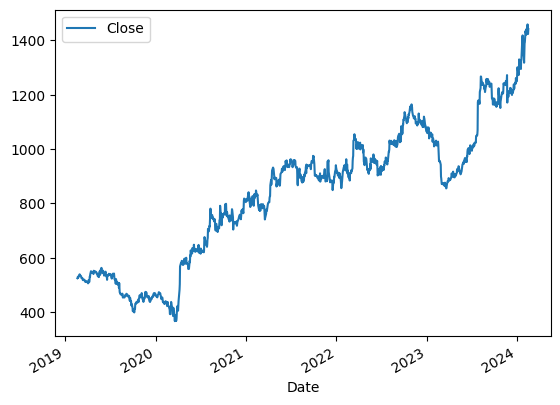

In [49]:
s2[['Close']].plot()

<Axes: xlabel='Date'>

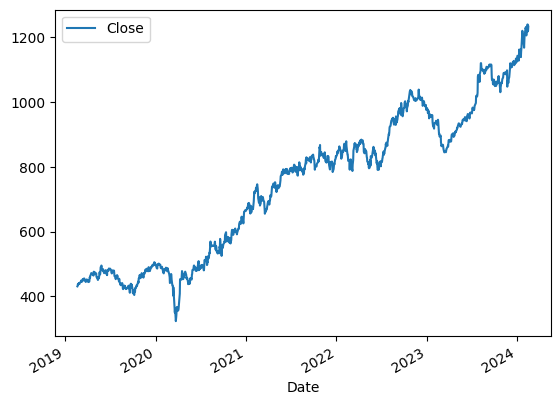

In [66]:
portfolio = pd.DataFrame()
wt1 = 0.5
wt2 = 0.5
# portfolio.index = icici.index
portfolio['Close'] = wt1*s1['Close'] + wt2*s2['Close']
portfolio['Prev. Close'] = wt1*s1['Prev. Close'] + wt2*s2['Prev. Close']
portfolio.dropna(inplace=True)
portfolio[['Close']].plot()

In [64]:
portfolio['Return'] = portfolio['Close']/portfolio['Prev. Close'] - 1 
portfolio['Return']*100

Date
2019-02-19 00:00:00+05:30    0.343714
2019-02-20 00:00:00+05:30    0.385616
2019-02-21 00:00:00+05:30    1.186339
2019-02-22 00:00:00+05:30   -0.382998
2019-02-25 00:00:00+05:30    1.180457
                               ...   
2024-02-12 00:00:00+05:30   -0.799855
2024-02-13 00:00:00+05:30    1.921139
2024-02-14 00:00:00+05:30   -1.190692
2024-02-15 00:00:00+05:30   -0.369681
2024-02-16 00:00:00+05:30    1.022958
Name: Return, Length: 1234, dtype: float64

In [65]:
abs_return = portfolio['Close'].iloc[-1] / portfolio['Close'].iloc[0] - 1
print(f"Absolute return : {(abs_return * 100):.2f}%")
CAGR = (portfolio['Close'].iloc[-1] / portfolio['Close'].iloc[0]) ** (1/YEARS) - 1
print(f"CARG : {(CAGR * 100):.2f}%")
print(f"Annual Standard Deviation: {portfolio['Return'].std()*100*(252**0.5):.2f}")

Absolute return : 185.85%
CARG : 23.37%
Annual Standard Deviation: 22.66


So in terms of returns it is slightly reduced but it has also reduced the standard deviation significantly

|Portfolio|CAGR (%)|Annual Volatility (%)|
|-|-|-|
|ICICI|24.9%|32.8|
|CIPLA|22.35|27.49|
|ICIC+CIPLA|23.37%|22.66|


So in conclusion

* If you have to pick a stocks/portfolios for investment giving same expected return but different standard deviation, stocks/portfolio with lowest volatility is preferred
* We can combine certain stocks to reduce risk while maintaining the returns at similar levels, this is called diversification

Now the question is, can we combine any stocks to reduce risk?


### But why did the volatility reduce?

It is because I chose two stocks which were **uncorrelated**. What is correlation? Correlation is a statistical measure that expresses the extent to which two variables are linearly related (meaning they change together at a constant rate).

$$correlation = \frac {cov(x,y)}{\sigma_x . \sigma_y}$$

Where

$$ cov(x,y) = \frac {\sum {(x-\mu_x)(y-\mu_y)}}{N} $$

Again we dont need to calculate this manually, pandas provides formula directly

#### How to interprete correlation?

The correlation coefficient value can be anywhere between -1 to 1. 

| Correlation | Interpretation |
|-------------|----------------|
|Close to 1   | Variables are strongly related, and move in same direction |
|Close to 0   | Variables are not related to each other at all |
|Close to -1  | Variables are strongly related, but move opposite to each other |



In [67]:
returns = pd.DataFrame()

In [68]:
returns['s1'] = s1['Return']
returns['s2'] = s2['Return']

In [69]:
returns.corr()

,s1,s2
s1,1.000000,0.155794
s2,0.155794,1.000000


As you can see the correlation coefficient is closer to 0 and there is no correlation or we can say negligible correlation. Because of this their when we combine them in same portfolio it results in lower standard deviation.



## Modern portfolio theory

What we learnt is the basis for one of the most important investment theory, Modern portfolio theory, it allows investors to assemble a portfolio of assets that maximizes expected return for a given level of risk. `Markovitz` received his Nobel prize in 1990 for his work on this theory.

* Say there are $N$ stocks to select in portfolio, what we want to find is what should be weight $w_i$ of each stock in the portfolio
* There are infinite number of portfolios possible but we want to select a subset of such portfolio where risk is lowest for given expected return

<div>
<img src="https://swapniljariwala.github.io/efficient-frontier.png" width="500"/>
</div>

So basically if you have say 10 favorite stocks, but you are not sure how to decide the weights for each stock. You can say large number of say 10000 combinations of random weights and calculate return and risk for each of the combination and select a combination which gives you best return for lowest risk possible.


## Recap of what we learnt so far

* How to measure stock returns
* What is risk and how to measure it
* What is correlation
* How to use correlation for minimizing risk
